In [1]:
import numpy as np
import pandas as pd
import json
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn import metrics

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
business_df = pd.read_csv("restaurant.csv")
review_df = pd.read_csv("review.csv")
user_df = pd.read_csv("user.csv")

In [4]:
business_df.drop(columns = 'Unnamed: 0', inplace = True)
business_loc = business_df.iloc[:, [0,3, 4, 5, 6, 7]]
user_useful = user_df.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
user_useful.set_index('user_id', inplace = True)
review_df.drop(columns = 'Unnamed: 0', inplace=True)
rJoinU = review_df.join(user_useful, on = 'user_id', lsuffix='_Rev', rsuffix = '_User')
rJoinU.dropna(inplace = True)
business_loc.set_index('business_id', inplace= True)
rJUJBloc = rJoinU.join(business_loc, on='business_id', lsuffix='_rJU', rsuffix='_bloc')
rJUJBloc.dropna(inplace= True)
hometown = rJUJBloc.groupby(['user_id'])['city'].agg(lambda x: pd.Series.mode(x)[0]).to_frame()

In [5]:
data = rJUJBloc.merge(hometown, how = 'left', on="user_id", suffixes=('_x', '_y'))
data['is_home'] = (data['city_x'] == data['city_y']).astype(int)

In [6]:
data['time_since'] = (pd.Timestamp(2022, 11, 29) - pd.to_datetime(data.date)).dt.days
merged = business_df.merge(review_df, on='business_id')
merged.dropna(inplace=True)
merged['goodReview'] = (merged['stars_x'] < merged['stars_y']).astype(int)
goodRev = merged.loc[:, ['review_id','business_id', 'stars_x', 'goodReview']]
goodRev.rename(columns={'stars_x': 'stars_bus'}, inplace=True)
dataFull = data.merge(goodRev, on='review_id')

In [7]:
elite = data.loc[:, ['user_id', 'elite']]
elite['glitch'] = elite['elite'].str.contains('20,20').astype(int)
elite['elite'] = elite['elite'].str.split(',')
elite['count'] = elite['elite'].apply(lambda x: len(x))
elite['trueCount'] = elite['count'] - elite['glitch']
elite.drop(columns=['elite', 'glitch', 'count'], inplace = True)
elite = elite.rename(columns={'trueCount': 'eliteCount'})
elite = elite.drop_duplicates(subset = 'user_id')
dataFull = dataFull.merge(elite, how = 'left', on = 'user_id')
friends = data.loc[:, ['user_id', 'friends']]
friends['numFriends'] = friends.friends.str.split(',').apply(lambda x: len(x))
friends.drop(columns = 'friends', inplace = True)
friends = friends.drop_duplicates(subset='user_id')
dataFull = dataFull.merge(friends, how = 'left', on = 'user_id')
dataFull = dataFull.drop_duplicates(subset='review_id')
business_df.loc[1, 'attributes']

'{\'BusinessParking\': \'None\', \'BusinessAcceptsCreditCards\': \'True\', \'RestaurantsAttire\': "u\'casual\'", \'OutdoorSeating\': \'True\', \'RestaurantsReservations\': \'False\', \'Caters\': \'False\', \'RestaurantsTakeOut\': \'True\', \'Alcohol\': "u\'none\'", \'Ambience\': \'None\', \'GoodForKids\': \'True\', \'RestaurantsPriceRange2\': \'1\', \'ByAppointmentOnly\': \'False\', \'CoatCheck\': \'False\', \'DogsAllowed\': \'False\', \'RestaurantsTableService\': \'False\', \'RestaurantsGoodForGroups\': \'True\', \'RestaurantsDelivery\': \'True\', \'WiFi\': "u\'no\'", \'WheelchairAccessible\': \'True\', \'HasTV\': \'True\', \'HappyHour\': \'False\', \'DriveThru\': \'True\', \'BikeParking\': \'False\'}'

In [8]:
# Restauran attributes from Jesse's data
restaurant_df = pd.read_csv('final_restaurant.csv')
onehot = restaurant_df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count' ])
dataFull.rename(columns={'business_id_x':'business_id'}, inplace = True)
dataFullFull = dataFull.merge(onehot, how = 'left', on = 'business_id')

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [10]:
# dataUseful = dataFull.loc[:, ['goodReview', 'review_count', 'useful_User', 'funny_User', 'cool_User', 'fans', 'average_stars', 'is_home', 'time_since', 'eliteCount', 'numFriends']]
# dataUseful = dataFullFull.drop(columns = ['review_id', 'user_id', 'business_id', 'stars', 'text', 'date', 'name', 'yelping_since', 'elite', 'friends', 'city_x', 'state', 'postal_code', 'latitude', 'longitude', 'city_y', 'business_id_y', 'stars_bus' ])

In [11]:
# simpleData = dataFull.loc[:, ['goodReview', 'review_count', 'useful_User', 'funny_User', 'cool_User', 'fans', 'average_stars', 'is_home', 'time_since', 'eliteCount', 'numFriends']]
simpleData = dataFull.loc[:, ['goodReview', 'review_count', 'average_stars', 'is_home', 'time_since']]

In [12]:
# corrmat = dataUseful.corr()
# f, ax = plt.subplots(figsize = (12, 10))
# mask = np.triu(np.ones_like(corrmat, dtype=bool))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corrmat, annot=True, mask = mask, cmap = cmap)
# plt.show()

In [13]:
y = simpleData['goodReview']
X = simpleData.loc[:, 'review_count':]
scaler = MinMaxScaler()
X_ss = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_ss, y, test_size=0.3)
from sklearn.neighbors import KNeighborsClassifier

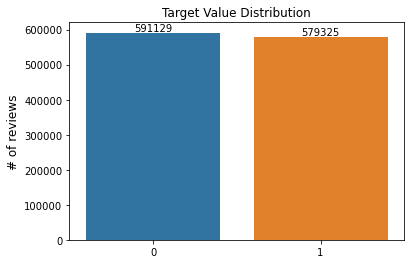

In [14]:
ax = sns.barplot(x=y.value_counts().index, y=y.value_counts())
plt.title("Target Value Distribution")
plt.ylabel("# of reviews", fontsize=12)
for i in ax.containers:
    ax.bar_label(i,)

In [15]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [16]:
# searchSpace = {
#     'n_neighbors': range(1,25)
# }
# gs = GridSearchCV(KNeighborsClassifier(), searchSpace, cv=5, scoring = 'f1_macro')
# gs.fit(xtrain, ytrain)
# print(gs.best_estimator_)

In [17]:
neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(xtrain, ytrain)
yhat = neigh.predict(xtest)
y_proba = neigh.predict_proba(xtest)

In [18]:
report = classification_report(ytest, yhat, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.582     0.612     0.597    177132
           1      0.584     0.553     0.568    174005

    accuracy                          0.583    351137
   macro avg      0.583     0.583     0.582    351137
weighted avg      0.583     0.583     0.583    351137



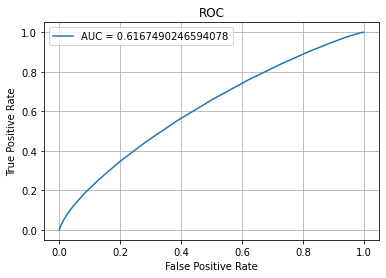

In [19]:
fpr, tpr, thresh = metrics.roc_curve(ytest, y_proba[:, 1])
auc = metrics.roc_auc_score(ytest, y_proba[:, 1])
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc))
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

### Logistic

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
logit = LogisticRegression(penalty='none').fit(xtrain, ytrain)

In [22]:
yhat = logit.predict(xtest)
y_proba = logit.predict_proba(xtest)

In [23]:
report = classification_report(ytest, yhat, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.598     0.615     0.606    177132
           1      0.597     0.580     0.588    174005

    accuracy                          0.597    351137
   macro avg      0.597     0.597     0.597    351137
weighted avg      0.597     0.597     0.597    351137



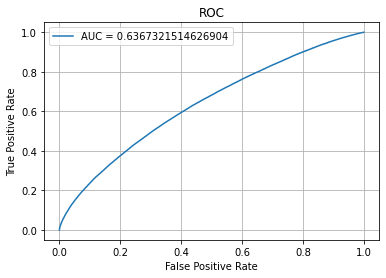

In [24]:
fpr, tpr, thresh = metrics.roc_curve(ytest, y_proba[:, 1])
auc = metrics.roc_auc_score(ytest, y_proba[:, 1])
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc))
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
# searchSpace = {
#     'max_depth': range(1,20),
#     'min_samples_leaf': range(1,20)
# }
# gs = GridSearchCV(DecisionTreeClassifier(), searchSpace, cv=5, scoring = 'f1_macro')
# gs.fit(xtrain, ytrain)
# print(gs.best_estimator_)

In [27]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=14)
dt.fit(xtrain, ytrain)
yhat = dt.predict(xtest)
y_proba = dt.predict_proba(xtest)

In [28]:
report = classification_report(ytest, yhat, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.597     0.619     0.608    177132
           1      0.597     0.575     0.586    174005

    accuracy                          0.597    351137
   macro avg      0.597     0.597     0.597    351137
weighted avg      0.597     0.597     0.597    351137



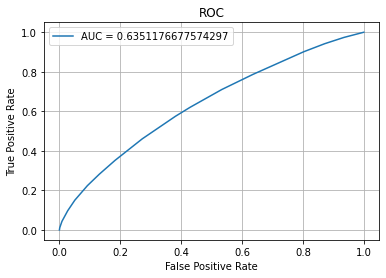

In [29]:
fpr, tpr, thresh = metrics.roc_curve(ytest, y_proba[:, 1])
auc = metrics.roc_auc_score(ytest, y_proba[:, 1])
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc))
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

### SVM

In [30]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [31]:
# searchSpace = {'C': [0.1,1, 10, 100], 
#                 'gamma': [1,0.1,0.01,0.001],
#                 'kernel': ['rbf', 'poly', 'sigmoid']
# }
# gs = GridSearchCV(SVC(), searchSpace, cv = 5, scoring = 'f1_macro')
# gs.fit(xtrain, ytrain)
# print(gs.best_estimator_)

In [33]:
svm = LinearSVC(dual=False).fit(xtrain, ytrain)
clf = CalibratedClassifierCV(svm) 
clf.fit(xtrain, ytrain)
y_proba = clf.predict_proba(xtest)
yhat = svm.predict(xtest)

In [34]:
report = classification_report(ytest, yhat, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.598     0.614     0.606    177132
           1      0.596     0.580     0.588    174005

    accuracy                          0.597    351137
   macro avg      0.597     0.597     0.597    351137
weighted avg      0.597     0.597     0.597    351137



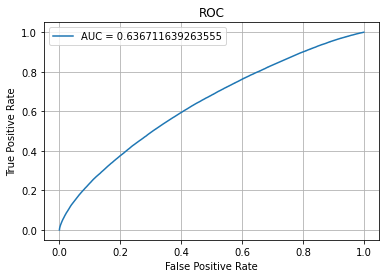

In [35]:
fpr, tpr, thresh = metrics.roc_curve(ytest, y_proba[:, 1])
auc = metrics.roc_auc_score(ytest, y_proba[:, 1])
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc))
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
# searchSpace = {
#     'n_estimators': range(10,15),
#     'max_depth': range(1,10),
#     'min_samples_leaf': range(1,20)
# }
# gs = GridSearchCV(RandomForestClassifier(), searchSpace, cv=5, scoring='f1_macro')
# gs.fit(xtrain, ytrain)
# print(gs.best_estimator_)

In [38]:
rf = RandomForestClassifier(n_estimators = 15, max_depth = 5, min_samples_leaf = 15)
rf.fit(xtrain, ytrain)
yhat = rf.predict(xtest)
y_proba = rf.predict_proba(xtest)

In [39]:
report = classification_report(ytest, yhat, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.585     0.698     0.637    177132
           1      0.618     0.497     0.551    174005

    accuracy                          0.598    351137
   macro avg      0.602     0.597     0.594    351137
weighted avg      0.601     0.598     0.594    351137



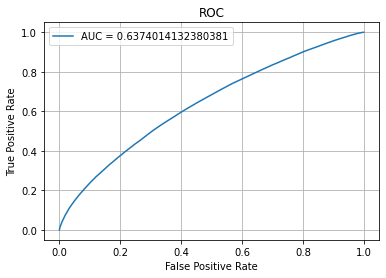

In [40]:
fpr, tpr, thresh = metrics.roc_curve(ytest, y_proba[:, 1])
auc = metrics.roc_auc_score(ytest, y_proba[:, 1])
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc))
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

### Perceptron

In [41]:
from sklearn.linear_model import Perceptron

In [44]:
perceptron = Perceptron()
perceptron.fit(xtrain, ytrain)
clf = CalibratedClassifierCV(perceptron) 
clf.fit(xtrain, ytrain)
yhat = perceptron.predict(xtest)
y_proba = clf.predict_proba(xtest)

In [45]:
report = classification_report(ytest, yhat, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.654     0.162     0.259    177132
           1      0.517     0.913     0.660    174005

    accuracy                          0.534    351137
   macro avg      0.585     0.537     0.460    351137
weighted avg      0.586     0.534     0.458    351137



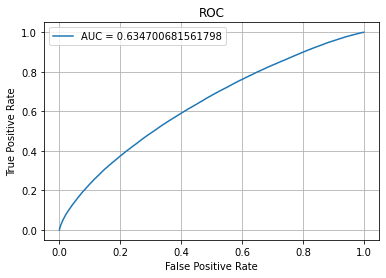

In [46]:
fpr, tpr, thresh = metrics.roc_curve(ytest, y_proba[:, 1])
auc = metrics.roc_auc_score(ytest, y_proba[:, 1])
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc))
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

### Gradient Boosting

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(xtrain, ytrain)
yhat = gb.predict(xtest)
y_proba = gb.predict_proba(xtest)

In [48]:
report = classification_report(ytest, yhat, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.592     0.660     0.624    177132
           1      0.608     0.538     0.571    174005

    accuracy                          0.599    351137
   macro avg      0.600     0.599     0.598    351137
weighted avg      0.600     0.599     0.598    351137



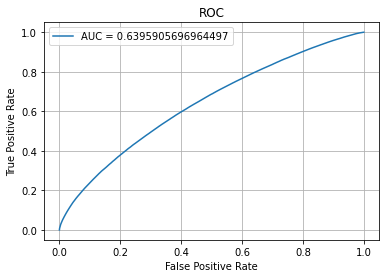

In [49]:
fpr, tpr, thresh = metrics.roc_curve(ytest, y_proba[:, 1])
auc = metrics.roc_auc_score(ytest, y_proba[:, 1])
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc))
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()